In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
cancer = load_breast_cancer()

In [4]:
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


In [5]:
cancer.data[:3]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [6]:
np.unique(cancer.target, return_counts=True)

(array([0, 1]), array([212, 357]))

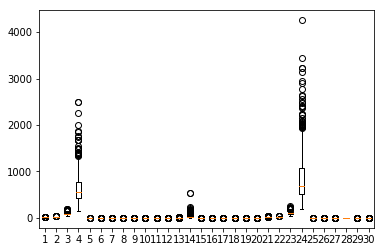

In [7]:
plt.boxplot(cancer.data)
plt.show()

In [8]:
X = cancer.data
y = cancer.target

In [9]:
np.random.seed(42)

In [10]:
class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        
    def forpass(self, x):
        x = np.insert(x, 1, 0)    # 편향을 추가합니다
        z = np.sum(x * self.w)    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        x = np.insert(x, 1, 0)   # 편향을 추가합니다
        w_grad = x * err         # 가중치에 대한 그래디언트를 계산합니다
        return w_grad
    
    def fit(self, X, y, epochs=100):
        self.w = np.random.uniform(-1, 1, X.shape[1]+1) # 가중치를 초기화합니다
        for i in range(epochs):                    # 에포크만큼 반복합니다
            for x_i, y_i in zip(X, y):             # 모든 샘플에 대해 반복합니다
                z = self.forpass(x_i)              # 정방향 계산
                g = self.activation(z)             # 활성화 함수 적용
                error = y_i - g                    # 오차 계산
                w_grad = self.backprop(x_i, error) # 역방향 계산
                self.w += w_grad                   # 가중치 업데이트
                
    def activation(self, z):
        g = 1 / (1 + np.exp(-z))                   # 시그모이드 계산
        return g
    
    def predict(self, x):
        z = self.forpass(x)                        # 정방향 계산
        g = self.activation(z)                     # 활성화 함수 적용
        return g >= 0.5

In [11]:
neuron = LogisticNeuron()
neuron.fit(X, y)

In [12]:
count = 0
for x_i, y_i in zip(X, y):
    if neuron.predict(x_i) == y_i:
        count += 1
print(count/X.shape[0])

0.7135325131810193


In [13]:
class Layer:
    
    def __init__(self):
        self.w = None
        
    def add_bias(self, X):
        a_column_all_1 = np.ones((X.shape[0], 1))   # 모두 1로 채워진 컬럼 벡터를 만듭니다
        return np.hstack((a_column_all_1, X))       # 행렬의 맨 앞에 컬럼 벡터를 추가합니다
    
    def forpass(self, X):
        X_b = self.add_bias(X)     # 편향을 추가합니다
        z = np.dot(X_b, self.w)    # 샘플마다 가중치를 곱하여 더합니다
        return z

    def backprop(self, x, err):
        X_b = self.add_bias(X)
        w_grad = np.dot(X_b.T, err) / X.shape[0]  # 가중치에 대한 그래디언트를 계산합니다
        return w_grad
    
    def fit(self, X, y, epochs=100):
        self.w = np.random.uniform(-1, 1, (X.shape[1]+1, 1)) # 가중치를 초기화합니다
        y = y.reshape(-1, 1)               # 컬럼 벡터로 변환합니다
        for i in range(epochs):            # 에포크만큼 반복합니다
            z = self.forpass(X)            # 정방향 계산
            g = self.activation(z)         # 활성화 함수 적용
            err = y - g                    # 오차 계산
            w_grad = self.backprop(X, err) # 역방향 계산
            self.w += w_grad               # 가중치 업데이트

    def activation(self, z):
        g = 1 / (1 + np.exp(-z))           # 시그모이드 계산
        return g
    
    def predict(self, X):
        z = self.forpass(X)                # 정방향 계산
        return z >= 0

In [14]:
np.random.seed(42)

In [15]:
layer = Layer()
layer.fit(X, y)

In [16]:
np.mean(layer.predict(X) == y.reshape(-1, 1))

0.7135325131810193